In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from pandas_datareader import data as pdr
from pandas_datareader.data import DataReader
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
%matplotlib inline
import numpy as np
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [2]:
df = pd.read_csv(r'..\stocks\AAPL.csv', index_col=['Date'], parse_dates=['Date'])
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,26.342501,25.500000,25.652500,26.337500,270597600.0,24.364536
2016-01-05,26.462500,25.602501,26.437500,25.677500,223164000.0,23.753977
2016-01-06,25.592501,24.967501,25.139999,25.174999,273829600.0,23.289116
2016-01-07,25.032499,24.107500,24.670000,24.112499,324377600.0,22.306208
2016-01-08,24.777500,24.190001,24.637501,24.240000,283192000.0,22.424154


### Data Frame ‘Company_name’, ‘Date’, ‘High’, ‘Low’, ‘Open’ ,‘Close’, ‘Volume’, ‘Adj. Close’. 
* Volume is the number of shares that changed hands (Traded) during a given day. 
* Adj closing price (used to examine historical returns) factors in anything that might affect the stock price after the market is closed.

In [3]:
df.shape

(1287, 6)

In [4]:
# Described Apple’s stock data
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1287.000000,1287.000000,1287.000000,1287.000000,1.287000e+03,1287.000000
mean,54.078615,52.922139,53.490647,53.528772,1.330349e+08,52.326800
std,28.825428,27.909174,28.404750,28.381491,6.112463e+07,28.836216
min,22.917500,22.367500,22.500000,22.584999,4.544800e+07,21.134403
25%,36.019999,35.561251,35.821251,35.813749,9.264660e+07,34.070679
50%,44.807499,44.000000,44.325001,44.259998,1.159644e+08,42.982357
75%,61.802500,59.762501,60.745001,60.818748,1.550630e+08,60.059130
max,145.089996,141.369995,143.600006,143.160004,5.334788e+08,142.946396


In [5]:
df.nunique()

High         1225
Low          1240
Open         1240
Close        1239
Volume       1282
Adj Close    1269
dtype: int64

In [6]:
#cleaning the data
#check the missing data
df.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

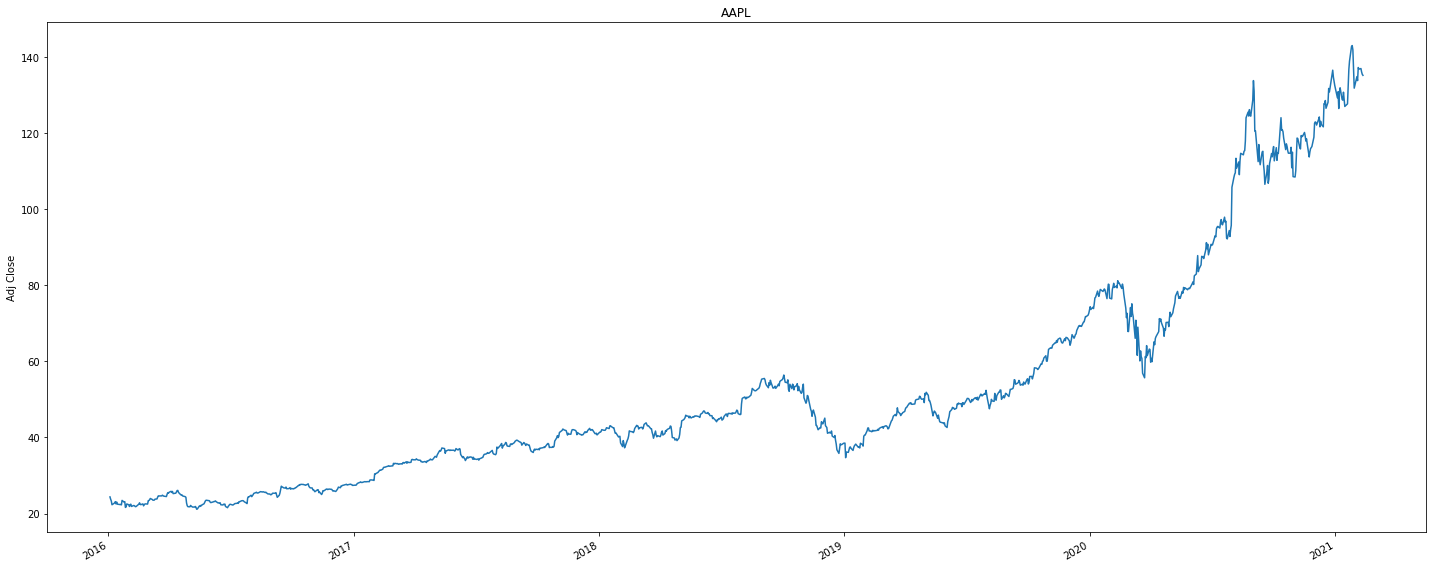

In [7]:
# To see a historical view of the closing price. For historical view I’ll be using Adj. Closing price
plt.figure(figsize=(20, 8))
df['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title('AAPL')
plt.tight_layout()

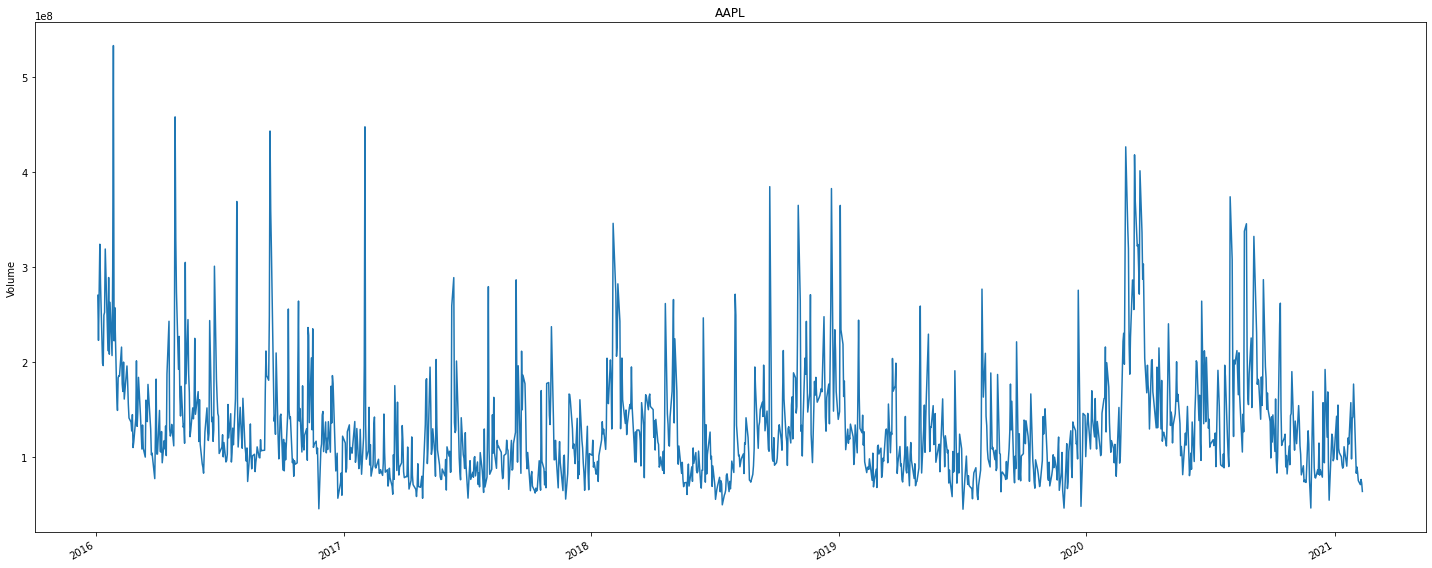

In [8]:
# For plotting the total volume of stock being traded each day
plt.figure(figsize=(20, 8))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title('AAPL')
plt.tight_layout()

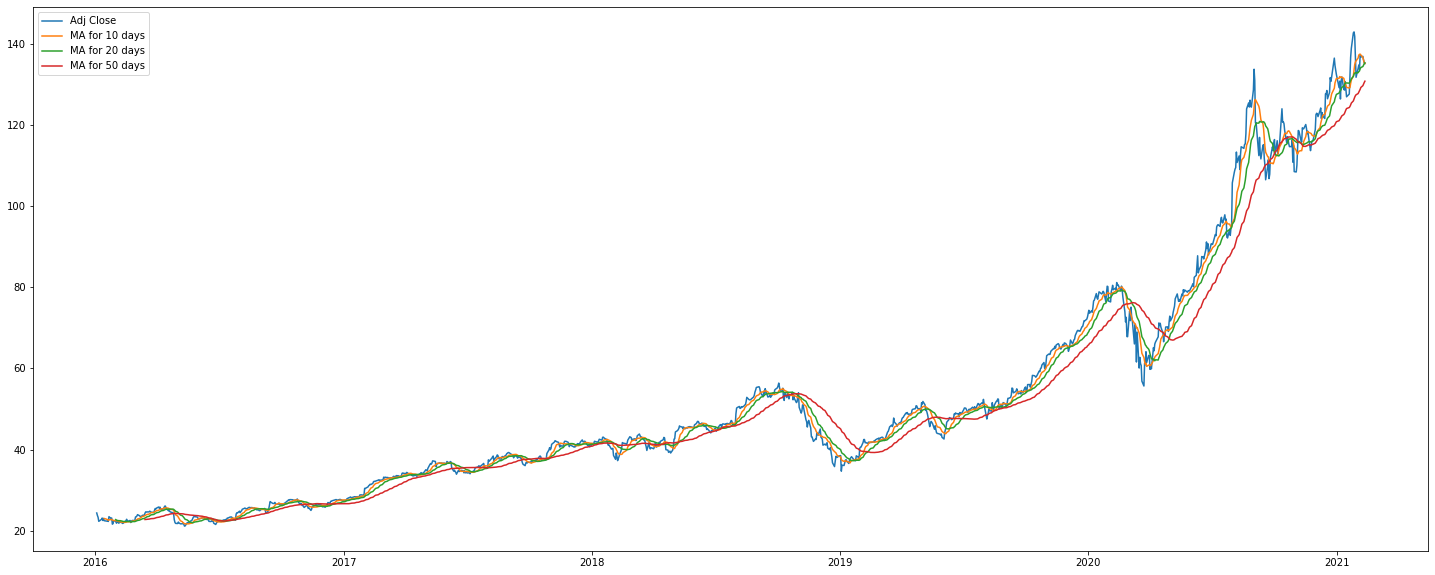

In [9]:
# Calculating Moving Average with lag of 10, 20, 50 days.
ma_day = [10, 20, 50]
for ma in ma_day:
    column_name = f'MA for {ma} days'
    df[column_name] = df['Adj Close'].rolling(ma).mean()

fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(df['Adj Close'], label= 'Adj Close')
ax.plot(df['MA for 10 days'], label='MA for 10 days')
ax.plot(df['MA for 20 days'], label='MA for 20 days')
ax.plot(df['MA for 50 days'], label='MA for 50 days')
ax.legend()
plt.show()

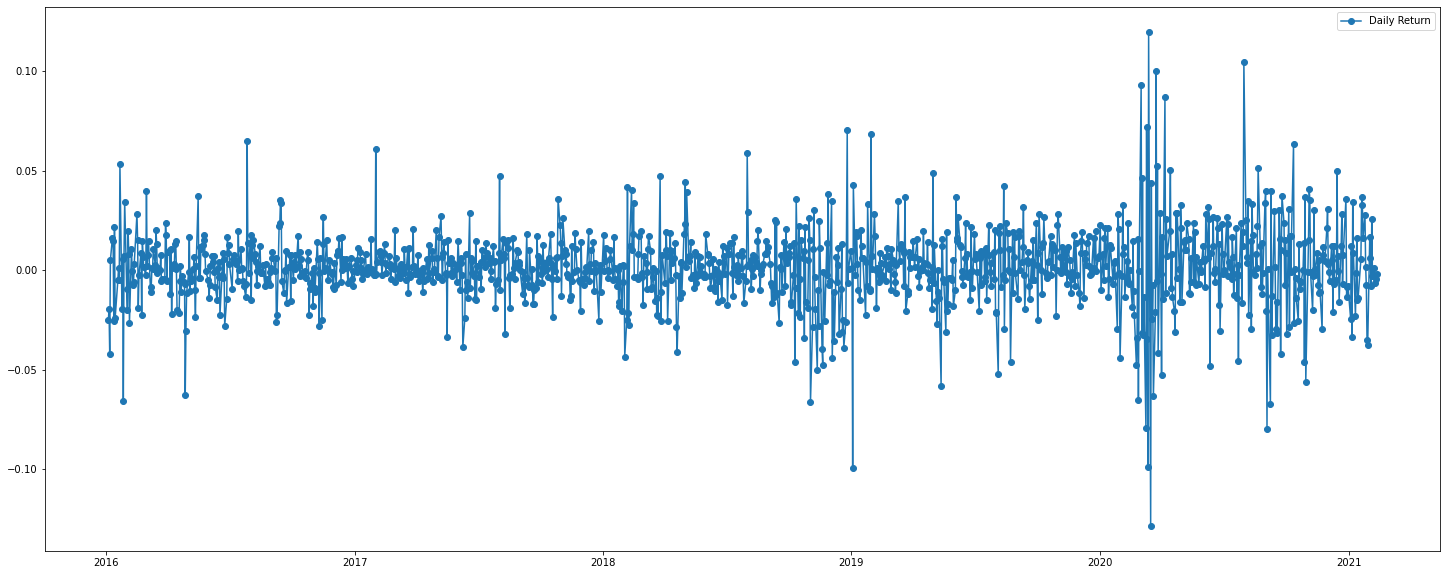

In [10]:
df['Daily Return'] = df['Adj Close'].pct_change()
    
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(df['Daily Return'], label= 'Daily Return', linestyle='-', marker='o')
ax.legend()
plt.show()

### Test for stationary series

In [11]:
df = pd.read_csv(r'..\stocks\AAPL.csv', index_col=['Date'], parse_dates=['Date'])
# Drop NaNs
df = df.dropna()
# Select the proper time period for daily aggreagation
df = df['2019-01-02':'2020-12-05'].resample('D').sum()
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,39.712502,38.557499,38.722500,39.480000,148158800.0,38.505024
2019-01-03,36.430000,35.500000,35.994999,35.547501,365248800.0,34.669640
2019-01-04,37.137501,35.950001,36.132500,37.064999,234428400.0,36.149662
2019-01-05,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2019-01-06,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


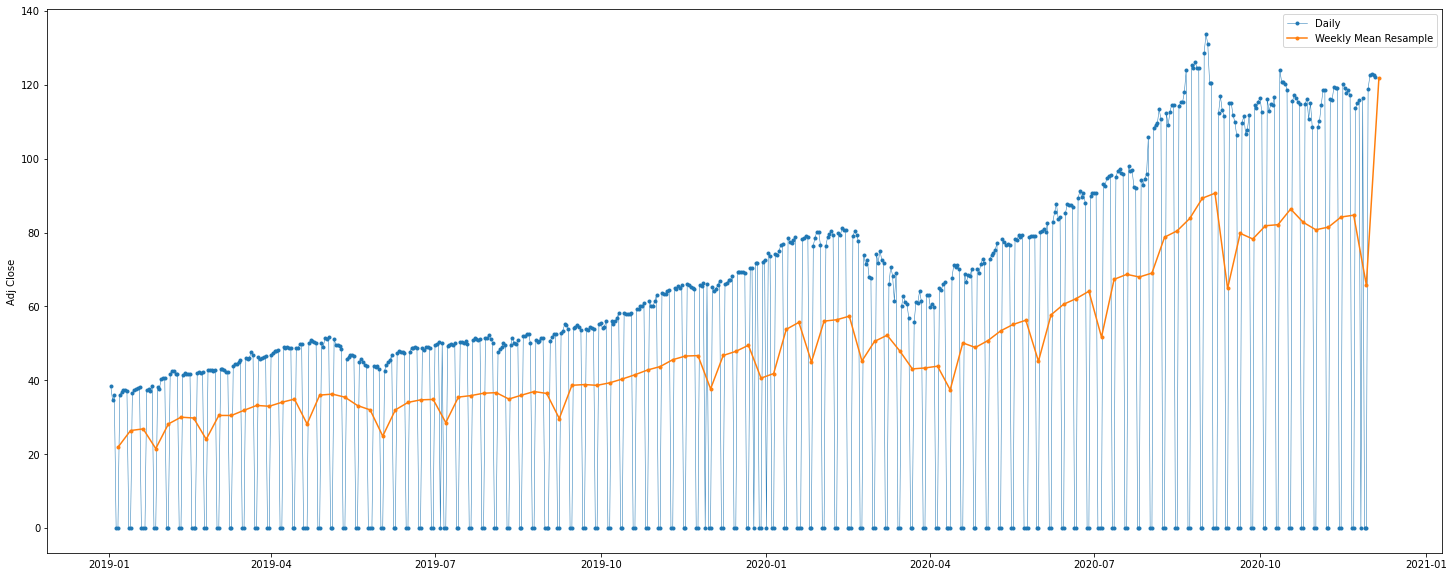

In [12]:
adj_close = df['Adj Close']
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(adj_close,marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(adj_close.resample('W').mean(),marker='o', markersize=3, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Adj Close')
ax.legend();

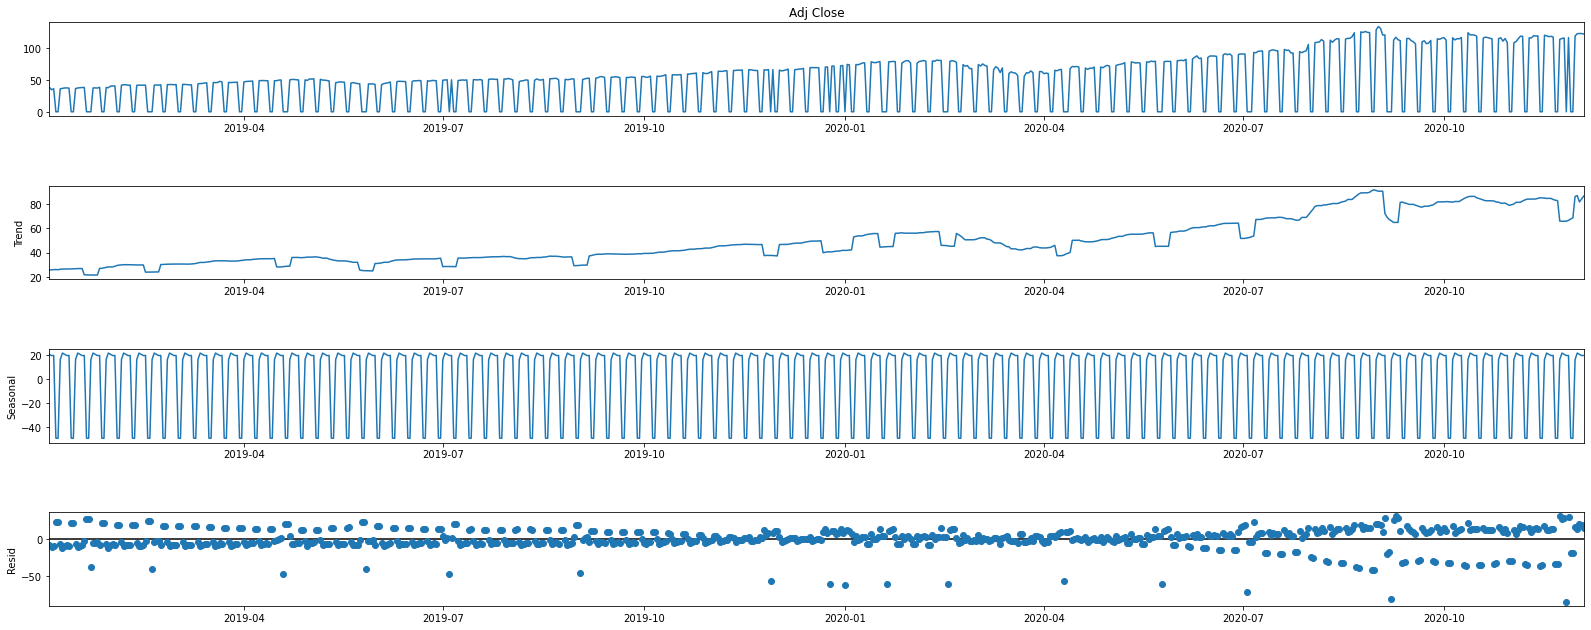

In [13]:
# graphs to show seasonal_decompose
def seasonal_decompose (adj_close):
    decomposition = sm.tsa.seasonal_decompose(adj_close, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(25, 10)
    plt.show()
    
seasonal_decompose(adj_close)

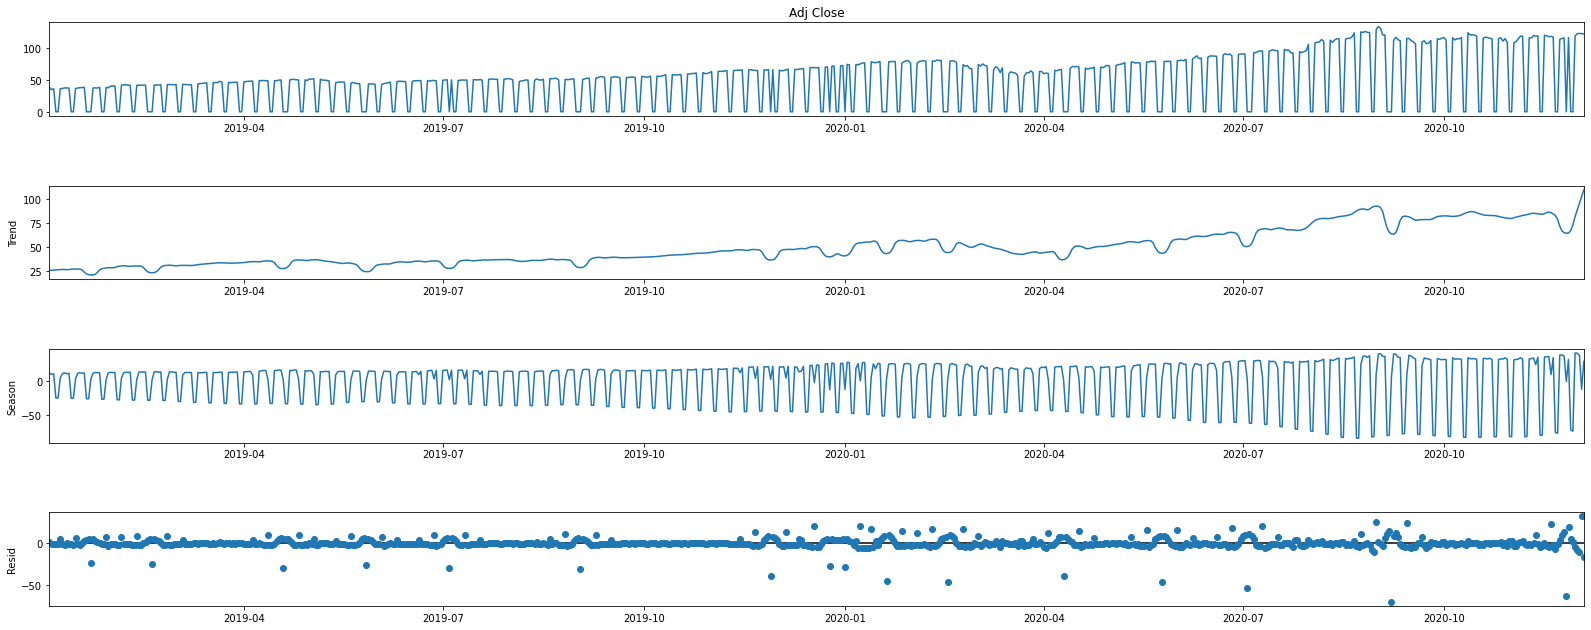

In [14]:
# graphs to show stl_decompose
def stl_decompose (adj_close):
    decomposition = STL(adj_close).fit()
    fig = decomposition.plot()
    fig.set_size_inches(25, 10)
    plt.show()

stl_decompose(adj_close)

### Check for Stationarity:

In [15]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

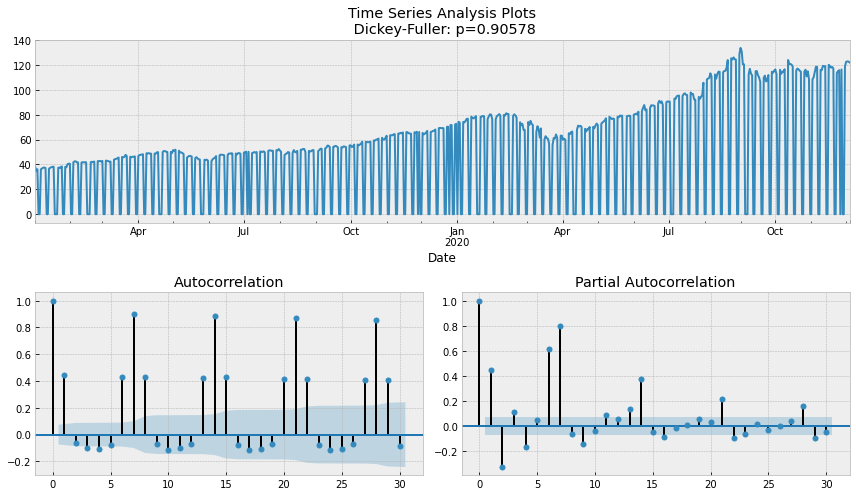

In [16]:
tsplot(df['Adj Close'], lags=30)

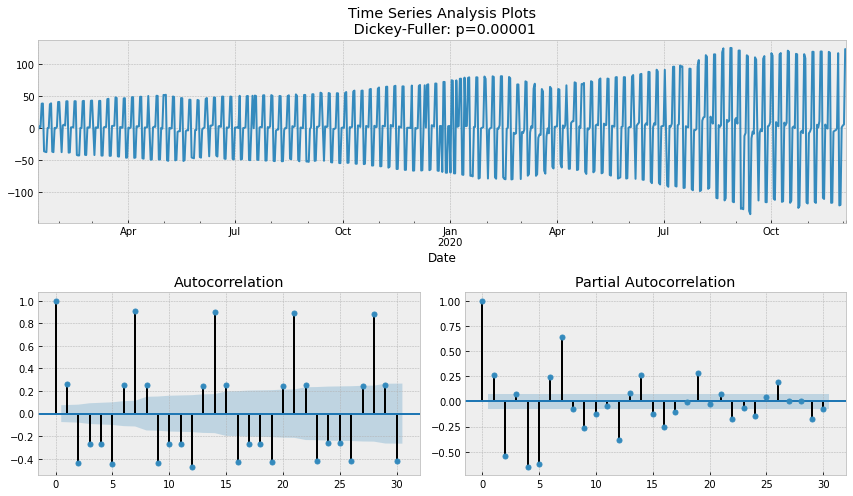

In [17]:
ads_diff = df['Adj Close'] - df['Adj Close'].shift(12)
tsplot(ads_diff[12:], lags=30)

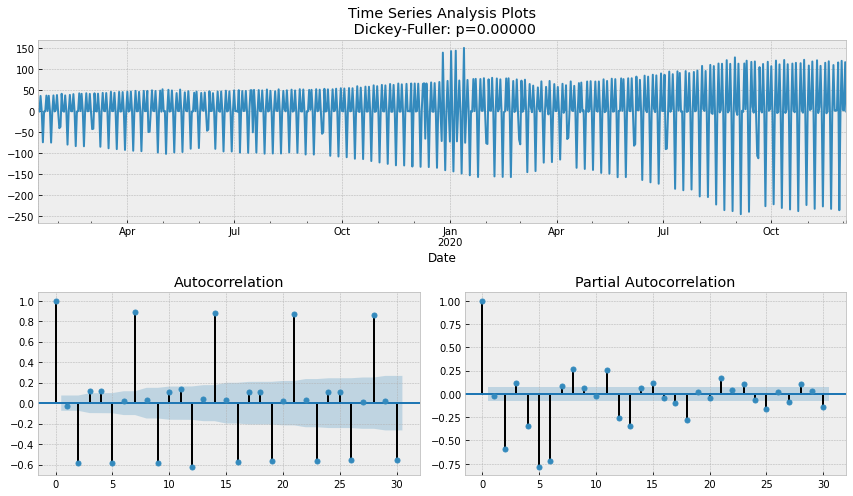

In [18]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[12+1:], lags=30)